In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import efficientnet.keras as efn

base_model = efn.EfficientNetB4(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()

Using TensorFlow backend.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
flatten_1 (Flatten)          (None, 87808)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                878090    
Total params: 18,551,906
Trainable params: 878,090
Non-trainable params: 17,673,816
_________________________________________________________________


In [2]:
import pandas as pd

df = pd.read_csv('input/all_images.csv')
df['file_name']=df['image_id']+'.jpg'
df=df[['file_name','dx','lesion_id']]
#df.head()

from sklearn.model_selection import train_test_split
label_dataframe=df.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(df, label_dataframe, test_size=0.1, random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train, y_train, test_size=0.4, random_state=42)
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)

(65, 2)
(97, 2)
(18, 2)


In [3]:
train=pd.concat([X_train,y_train],axis=1)
train.head()
val=pd.concat([X_val,y_val],axis=1)
val.head()
test=pd.concat([X_test,y_test],axis=1)
test.head()

,file_name,lesion_id,dx
19,0 (21).jpg,9,fungal_infection
42,0 (44).jpg,21,fungal_infection
153,0 (154).jpg,62,acne
78,0 (80).jpg,34,papule
145,0 (146).jpg,59,fungal_infection


In [4]:
from sklearn import preprocessing
vle = preprocessing.LabelEncoder()
vle.fit(val['dx'])
label=vle.transform(val['dx']) 
print(list(vle.classes_))
val['label']=label
print(train.head())
le_name_mapping = dict(zip(vle.classes_, vle.transform(vle.classes_)))
print(le_name_mapping)

trle = preprocessing.LabelEncoder()
trle.fit(train['dx'])
label=trle.transform(train['dx']) 
print(list(trle.classes_))
train['label']=label
print(train.head())
le_name_mapping = dict(zip(trle.classes_, trle.transform(trle.classes_)))
print(le_name_mapping)

le = preprocessing.LabelEncoder()
le.fit(test['dx'])
label=le.transform(test['dx']) 
print(list(le.classes_))
test['label']=label
print(test.head())
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

['acne', 'bacterial_infection', 'dermatitis', 'fungal_infection', 'hyperpigmentation', 'hypertrophy', 'mole', 'papule', 'scabies', 'skin_virus']
       file_name  lesion_id                dx
44    0 (46).jpg         22            papule
148  0 (149).jpg         59  fungal_infection
141  0 (142).jpg         57              acne
83    0 (85).jpg         36  fungal_infection
96    0 (98).jpg         40  fungal_infection
{'acne': 0, 'bacterial_infection': 1, 'dermatitis': 2, 'fungal_infection': 3, 'hyperpigmentation': 4, 'hypertrophy': 5, 'mole': 6, 'papule': 7, 'scabies': 8, 'skin_virus': 9}
['acne', 'bacterial_infection', 'dermatitis', 'fungal_infection', 'hyperpigmentation', 'hypertrophy', 'mole', 'papule', 'scabies', 'skin_virus']
       file_name  lesion_id                dx  label
44    0 (46).jpg         22            papule      7
148  0 (149).jpg         59  fungal_infection      3
141  0 (142).jpg         57              acne      0
83    0 (85).jpg         36  fungal_infection  

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
rescale = 1./255,
featurewise_center=False,  # set input mean to 0 over the dataset
samplewise_center=False,  # set each sample mean to 0
featurewise_std_normalization=False,  # divide inputs by std of the dataset
samplewise_std_normalization=False,  # divide each input by its std
zca_whitening=False,  # apply ZCA whitening
rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
zoom_range = 0.4, # Randomly zoom image 
shear_range=0.2,
width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
horizontal_flip=True,  # randomly flip images
vertical_flip=True)  # randomly flip images)


In [6]:
train_data= train_generator.flow_from_dataframe(
dataframe=train,
x_col="file_name",
y_col="dx",
batch_size=4,
seed=311,
directory="input/test",
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 97 validated image filenames belonging to 10 classes.


In [7]:
test_generator=ImageDataGenerator(
rescale = 1./255)
test_data= test_generator.flow_from_dataframe(
dataframe=test,
x_col="file_name",
y_col="dx",
seed=45,
directory="input/test",
shuffle=False,
batch_size=1,
class_mode=None,
target_size=(224,224))

Found 18 validated image filenames.


In [8]:
val_data=test_generator.flow_from_dataframe(
dataframe=val,
directory="input/test",
x_col="file_name",
y_col="dx",
batch_size=1,
seed=45,
shuffle=False,
class_mode="categorical",
target_size=(224,224))

Found 65 validated image filenames belonging to 10 classes.


In [9]:
from sklearn.utils import class_weight
import numpy as np

class_weight = np.round(class_weight.compute_class_weight('balanced',np.unique(y_train),y_train['dx']))
print(class_weight)
print(train_data.class_indices)
print(val_data.class_indices)
print(train['dx'].value_counts())

[1. 1. 1. 0. 5. 2. 2. 1. 2. 2.]
{'acne': 0, 'bacterial_infection': 1, 'dermatitis': 2, 'fungal_infection': 3, 'hyperpigmentation': 4, 'hypertrophy': 5, 'mole': 6, 'papule': 7, 'scabies': 8, 'skin_virus': 9}
{'acne': 0, 'bacterial_infection': 1, 'dermatitis': 2, 'fungal_infection': 3, 'hyperpigmentation': 4, 'hypertrophy': 5, 'mole': 6, 'papule': 7, 'scabies': 8, 'skin_virus': 9}
fungal_infection       27
acne                   13
dermatitis             12
bacterial_infection    12
papule                 11
skin_virus              6
scabies                 5
hypertrophy             5
mole                    4
hyperpigmentation       2
Name: dx, dtype: int64


In [10]:
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
from keras.metrics import top_k_categorical_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                    patience=4, 
                                    verbose=1, 
                                    factor=0.2, 
                                    min_lr=0.0001)

In [11]:
model.compile(optimizer=SGD(lr=0.001, nesterov=True),loss="categorical_crossentropy",metrics=["accuracy", "top_k_categorical_accuracy"])
history=model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=20,
                            class_weight=class_weight,
                            callbacks=[learning_rate_reduction])

Epoch 1/20
24/24 [==============================] - 21s 882ms/step - loss: 3.1603 - accuracy: 0.1398 - top_k_categorical_accuracy: 0.6129 - val_loss: 0.3119 - val_accuracy: 0.2000 - val_top_k_categorical_accuracy: 0.6154
Epoch 2/20
24/24 [==============================] - 14s 568ms/step - loss: 2.7592 - accuracy: 0.2151 - top_k_categorical_accuracy: 0.6774 - val_loss: 1.2844 - val_accuracy: 0.2000 - val_top_k_categorical_accuracy: 0.5692
Epoch 3/20
24/24 [==============================] - 14s 591ms/step - loss: 2.8487 - accuracy: 0.2366 - top_k_categorical_accuracy: 0.6452 - val_loss: 2.0608 - val_accuracy: 0.1692 - val_top_k_categorical_accuracy: 0.6154
Epoch 4/20
24/24 [==============================] - 12s 503ms/step - loss: 2.4953 - accuracy: 0.2796 - top_k_categorical_accuracy: 0.7634 - val_loss: 1.1282 - val_accuracy: 0.3385 - val_top_k_categorical_accuracy: 0.6615
Epoch 5/20
24/24 [==============================] - 12s 513ms/step - loss: 2.7628 - accuracy: 0.2258 - top_k_categor

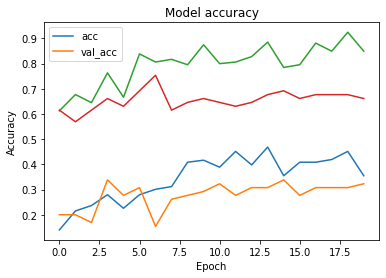

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

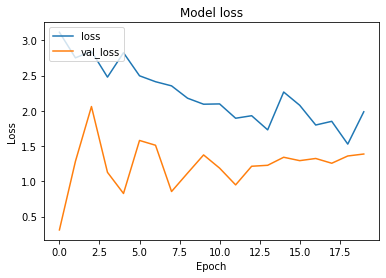

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [14]:
val_data.reset()
predictions = model.predict_generator(val_data, steps=val_data.samples/val_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)
print(y_pred)
ground_truth=val_data.classes

65/65 [==============================] - 8s 116ms/step
[0 7 3 7 2 5 7 5 0 7 7 7 2 2 3 7 0 7 2 7 3 4 3 3 7 1 7 7 7 9 3 7 3 4 0 8 7
 7 3 2 7 7 7 8 7 8 3 8 7 7 4 7 2 6 7 8 2 7 3 3 8 7 3 9 3]


In [15]:
from sklearn.metrics import classification_report
print('Classification Report')
target_names = ['acne', 'bacterial_infection', 'dermatitis', 'fungal_infection', 'hyperpigmentation', 'hypertrophy', 'mole', 'papule', 'scabies', 'skin_virus']
print(classification_report(val_data.classes, y_pred, target_names=target_names))

Classification Report
                     precision    recall  f1-score   support

               acne       0.50      0.25      0.33         8
bacterial_infection       0.00      0.00      0.00         6
         dermatitis       0.29      0.18      0.22        11
   fungal_infection       0.62      0.44      0.52        18
  hyperpigmentation       0.00      0.00      0.00         3
        hypertrophy       0.50      1.00      0.67         1
               mole       0.00      0.00      0.00         6
             papule       0.31      0.80      0.44        10
            scabies       0.00      0.00      0.00         1
         skin_virus       0.00      0.00      0.00         1

           accuracy                           0.32        65
          macro avg       0.22      0.27      0.22        65
       weighted avg       0.34      0.32      0.30        65



In [33]:
base_model.trainable = True
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
flatten_1 (Flatten)          (None, 87808)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                878090    
Total params: 1,003,290
Trainable params: 878,090
Non-trainable params: 125,200
_________________________________________________________________


In [34]:
model.compile(optimizer=SGD(lr=0.0001, nesterov=True),loss="categorical_crossentropy",metrics=["accuracy", "top_k_categorical_accuracy"])
history=model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=10,
                            class_weight=class_weight,
                            callbacks=[learning_rate_reduction])

Epoch 1/10
24/24 [==============================] - 39s 2s/step - loss: 1.6791 - accuracy: 0.4516 - top_k_categorical_accuracy: 0.8817 - val_loss: 1.2516 - val_accuracy: 0.2923 - val_top_k_categorical_accuracy: 0.6462
Epoch 2/10
24/24 [==============================] - 14s 568ms/step - loss: 1.5506 - accuracy: 0.4624 - top_k_categorical_accuracy: 0.8925 - val_loss: 1.3541 - val_accuracy: 0.2308 - val_top_k_categorical_accuracy: 0.6308
Epoch 3/10
24/24 [==============================] - 13s 552ms/step - loss: 1.6368 - accuracy: 0.4839 - top_k_categorical_accuracy: 0.8817 - val_loss: 1.1487 - val_accuracy: 0.2615 - val_top_k_categorical_accuracy: 0.6769
Epoch 4/10
24/24 [==============================] - 13s 555ms/step - loss: 1.8047 - accuracy: 0.4946 - top_k_categorical_accuracy: 0.9140 - val_loss: 0.9793 - val_accuracy: 0.2462 - val_top_k_categorical_accuracy: 0.7231
Epoch 5/10
24/24 [==============================] - 14s 566ms/step - loss: 1.6624 - accuracy: 0.4516 - top_k_categorica

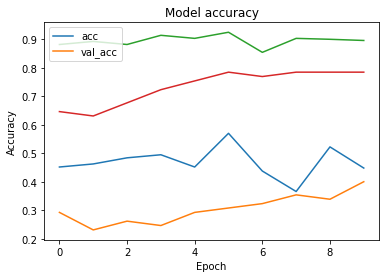

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

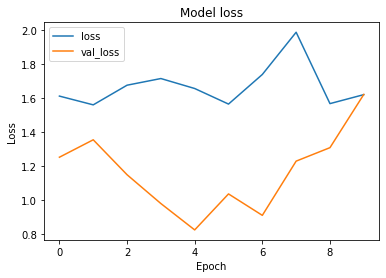

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [37]:
val_data.reset()
predictions = model.predict_generator(val_data, steps=val_data.samples/val_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)
print(y_pred)
ground_truth=val_data.classes

65/65 [==============================] - 8s 126ms/step
[8 7 3 7 0 4 4 7 8 7 6 7 7 7 3 0 0 3 8 6 3 1 3 3 8 7 8 7 8 0 3 8 3 1 0 3 7
 7 3 1 0 1 3 1 7 6 3 8 4 1 3 7 0 0 6 7 9 7 3 3 9 7 1 0 8]


In [38]:
from sklearn.metrics import classification_report
print('Classification Report')
target_names = ['acne', 'bacterial_infection', 'dermatitis', 'fungal_infection', 'hyperpigmentation', 'hypertrophy', 'mole', 'papule', 'scabies', 'skin_virus']
print(classification_report(val_data.classes, y_pred, target_names=target_names))

Classification Report
                     precision    recall  f1-score   support

               acne       0.56      0.62      0.59         8
bacterial_infection       0.43      0.50      0.46         6
         dermatitis       0.00      0.00      0.00        11
   fungal_infection       0.60      0.50      0.55        18
  hyperpigmentation       0.00      0.00      0.00         3
        hypertrophy       0.00      0.00      0.00         1
               mole       0.75      0.50      0.60         6
             papule       0.38      0.60      0.46        10
            scabies       0.00      0.00      0.00         1
         skin_virus       0.00      0.00      0.00         1

           accuracy                           0.40        65
          macro avg       0.27      0.27      0.27        65
       weighted avg       0.40      0.40      0.39        65



In [39]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

18/18 [==============================] - 2s 88ms/step


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

18/18 [==============================] - 2s 85ms/step


In [41]:
ground_truth=test['label']
print('Confusion Matrix')
print(confusion_matrix(ground_truth, y_pred))

Confusion Matrix
[[0 0 0 0 0 0 0 2 0]
 [0 0 0 1 0 0 0 2 0]
 [1 0 0 4 1 0 0 1 0]
 [0 0 0 1 0 0 0 1 0]
 [0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [42]:
from keras.models import load_model

model.save('fine_original_data.h5')